In [125]:
!pip install gcsfs

In [152]:
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn import linear_model, datasets
from sklearn.preprocessing import PolynomialFeatures
import itertools
import matplotlib as mpl
import matplotlib.style
mpl.style.use('seaborn-bright')
%matplotlib inline

In [153]:
fs = gcsfs.GCSFileSystem(project='omina-gcp-resource')
with fs.open('omina-test-set/occupancy-data/occupancy_data.csv') as f:
    df = pd.read_csv(f)

In [154]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['Unnamed: 0']

In [155]:
df = df.sort_values(by='date')

In [156]:
df_group = df.groupby(pd.Grouper(key = 'date', freq = 'D'))
df['NSM'] = df.date.apply(lambda x: x - x.replace(hour=0, minute=0, second=0)).dt.total_seconds()
df['WS'] = ((pd.DatetimeIndex(df.index).dayofweek) < 5).astype(int)
df = df[df['WS'] == 1]
del df['date']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
date,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,51540.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,51599.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,51660.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,51720.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,51780.0,1


In [157]:
df['day'] = df.index.day
df['hour'] = df.index.hour
df = df.reset_index().groupby(['day', 'hour']).mean()
df.head()

Temperature   Humidity       Light          CO2  HumidityRatio  \
day hour                                                                   
2   14      23.657118  27.023720  499.978107   898.784843       0.004889   
    15      23.293950  28.412430  456.719048  1103.186310       0.005030   
    16      22.773142  26.737452  434.838993   979.566003       0.004585   
    17      22.534520  24.972128  426.736158   822.562853       0.004217   
    18      21.993372  24.595967   32.984167   720.400278       0.004018   

          Occupancy           NSM   WS  
day hour                                
2   14     1.000000  52739.658537  1.0  
    15     1.000000  55769.700000  1.0  
    16     1.000000  59399.688525  1.0  
    17     0.610169  62999.677966  1.0  
    18     0.083333  66569.700000  1.0

In [158]:
df = df[(df['CO2'] > 750) & (df['Humidity'] > 25)]
df = df[~((df['CO2'] > 1200) & (df['Humidity'] < 28))]
features = ['Humidity', 'CO2']
df_train = df[features]

In [159]:
X = df['Humidity'].as_matrix()
y = df['CO2'].as_matrix()
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

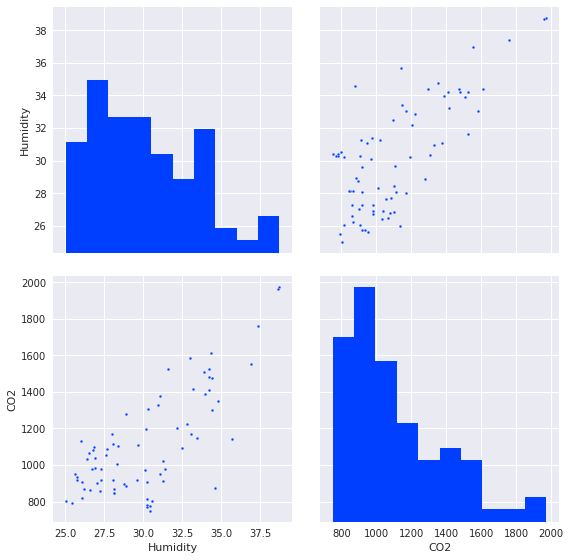

In [147]:
sns.set(style="white")
sns.set(color_codes=True)
sns.set_palette("bright", 2)
g = sns.pairplot(df_train,
                 size = 4,
                 plot_kws={"s": 8, 'alpha': 1},
                 vars=["Humidity", "CO2"])

Copying file://test_reg.svg [Content-Type=image/svg+xml]...
/ [1 files][ 30.1 KiB/ 30.1 KiB]                                                
Operation completed over 1 objects/30.1 KiB.                                     


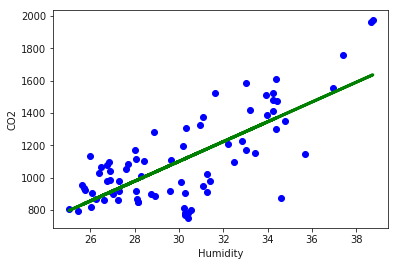

In [160]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
df_y_pred = regr.predict(X)

# Plot outputs
plt.scatter(X, y,  color='blue')
plt.plot(X, df_y_pred, color='green', linewidth=3)

plt.xlabel('Humidity')
plt.ylabel('CO2')
plt.savefig("test_reg.svg", format="svg")
!gsutil cp 'test_reg.svg' 'gs://omina-test-set/occupancy-data/fig_reg.svg'


Copying file://test_pol_reg.svg [Content-Type=image/svg+xml]...
/ [1 files][ 30.1 KiB/ 30.1 KiB]                                                
Operation completed over 1 objects/30.1 KiB.                                     


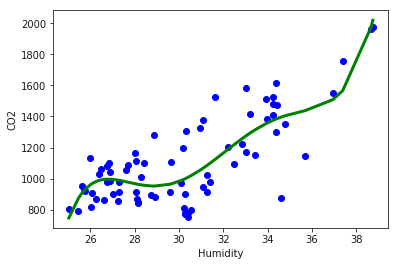

In [161]:
# create a Linear Regressor 
X_test = np.unique(abs(X))
X_test = X_test.reshape(-1, 1)
regr = linear_model.LinearRegression()

# pass the order of your polynomial here  
poly = PolynomialFeatures(5)

# convert to be used further to linear regression
X_transform = poly.fit_transform(X)
X_transform_test = poly.fit_transform(X_test)

# fit this to Linear Regressor
regr.fit(X_transform,y) 

# get the predictions
y_preds = regr.predict(X_transform_test)

# Plot outputs
plt.scatter(X, y,  color='blue')
plt.plot(X_test, y_preds, color='green', linewidth=3)

plt.xlabel('Humidity')
plt.ylabel('CO2')

plt.savefig("test_pol_reg.svg", format="svg")
!gsutil cp 'test_pol_reg.svg' 'gs://omina-test-set/occupancy-data/fig_pol_reg.svg'

In [151]:
plt.rcParams.update(plt.rcParamsDefault)